In [1]:
"""
 script to read the pan-Arctic IBCAO Bathymetry 

"""
import os,sys,re
import glob
#
import numpy as np
import matplotlib.pyplot as plt
#
from datetime import datetime
#
from netCDF4 import Dataset  
#
from osgeo import gdal, osr
#
import pandas as pd
#
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#
# load IBCAO bathymetry/topography image
#
def Restricted_Domain(longitude, latitude, lonmin, lonmax, latmin, latmax):
	
  # find longitude range
  lon, lat = longitude[0,:], latitude[:,0]
  ind_lonmin, ind_lonmax = np.argmin(abs(lon-lonmin)), np.argmin(abs(lon-lonmax))
	
  # find latitude range
  ind_latmin, ind_latmax = np.argmin(abs(lat-latmin)), np.argmin(abs(lat-latmax))
	
  longitude = longitude[ind_latmax:ind_latmin,ind_lonmin:ind_lonmax]
  latitude = latitude[ind_latmax:ind_latmin,ind_lonmin:ind_lonmax]
		
  return longitude, latitude, ind_lonmin, ind_lonmax, ind_latmin, ind_latmax
#  
def GetProjImgInfo(filein):
  #---------------------------------------------------------------------
  # Get the projected image resolution and longitude/latitude information 
  #---------------------------------------------------------------------

  # get image resolution
  ImgRes = GetImRes(filein) 

  # get projected coordinates
  longitude, latitude = GetCoordinates(filein)
  print ("Image Resolution (longitude/latitude): ",ImgRes)
	
  return longitude, latitude, ImgRes
#
def GetCoordinates(filein):
  #---------------------------------------------
  # Get image coordinates 
  #---------------------------------------------
  # image dimension	
  ImgSize = GetImSize(filein)
  # get domain corner coordinates
  Coords = GetCoords(filein)
  # initialization
  longitude = np.zeros(ImgSize,dtype=np.float32)
  latitude = np.zeros_like(longitude)
  # get latitude and longitude
  North_vals = np.linspace(Coords[:,1].min(),Coords[:,1].max(),ImgSize[0])
  for i in range(ImgSize[0]):
    longitude[i] = np.linspace(Coords[:,0].min(),Coords[:,0].max(),ImgSize[1])
    latitude[i] = np.ones((ImgSize[1]))*North_vals[i]
  latitude = latitude[::-1,:]
  return longitude, latitude
#
def GetImRes(filein):
  #------------------------------------------------
  # Get the projected image resolution information 
  #------------------------------------------------
  # gather image information using gdalinfo
  os.system("gdalinfo "+filein+" > Info_Coords.txt")
  # open file and read data 
  fid = open("Info_Coords.txt", "r")
  data = fid.readlines()
  # get the x and y axis resolution from information
  for n,line in enumerate(data):
    if re.match("Pixel Size", line):
      LineRec = n
  line = data[LineRec]
  
  xres = round(np.float(line.split(",")[0].split("(")[1]),2)
  yres = round(np.abs(np.float(line.split(",")[1].split(")")[0])),2)
  ImgRes = [yres,xres]
  fid.close()
  os.system("rm -f Info_Coords.txt")
  return ImgRes
#
def GetImSize(filein):
  #-------------------------
  # Get image dimension
  #-------------------------
  # gather image information using gdalinfo
  os.system("gdalinfo "+filein+" > Info_ImgSize.txt")
  # open file and read data 
  fid = open("Info_ImgSize.txt", "r")
  data = fid.readlines()
  #find the dimension information
  for n,line in enumerate(data):
    print (n,line)
    if re.search("Size is ", line):
      LineSize=n
  y = np.int(data[LineSize].split(" is ")[1].split(",")[1])
  x = np.int(data[LineSize].split(" is ")[1].split(",")[0])
  #store dimension and close (remove) file	
  ImgSize=[y,x]
  fid.close()
  os.system("rm -f Info_ImgSize.txt")
  return ImgSize 
#
def GetCoords(filein):
  #-------------------------------------
  # Get corresponding image coordinates 
  #-------------------------------------
  # gather image information using gdalinfo
  os.system("gdalinfo "+filein+" > Info_Coords.txt")
  # open file and read data 
  fid = open("Info_Coords.txt", "r")
  data = fid.readlines()
  #find the corner points coordinates from information
  for n,line in enumerate(data):
    if re.match("Corner Coordinates:", line):
      LineCoords = n
  Coords = [  [np.float(data[LineCoords+1].split("(")[1].split(",")[0]),np.float(data[LineCoords+1].split("(")[1].split(",")[1].split(")")[0])],
           [np.float(data[LineCoords+2].split("(")[1].split(",")[0]),np.float(data[LineCoords+2].split("(")[1].split(",")[1].split(")")[0])],
           [np.float(data[LineCoords+3].split("(")[1].split(",")[0]),np.float(data[LineCoords+3].split("(")[1].split(",")[1].split(")")[0])],
           [np.float(data[LineCoords+4].split("(")[1].split(",")[0]),np.float(data[LineCoords+4].split("(")[1].split(",")[1].split(")")[0])]]

  #store dimension and close (remove) file
  fid.close()
  os.system("rm -f Info_Coords.txt")
  Coords = np.array(Coords)
  return Coords
#
def ReadGtiffRaster(filein, datatype = 'uint16'):
  # read projected image and get rasterband
  f = gdal.Open(filein); a = f.GetRasterBand(1)

  # reconstitute image from raster
  if datatype == 'uint16':
    img = f.ReadAsArray(0, 0, a.XSize, a.YSize).astype(np.uint16)
  elif datatype == 'float32':
    img = f.ReadAsArray(0, 0, a.XSize, a.YSize).astype(np.float32)
	
  return f, a, img 
#
class Topography(object):
  def __init__(self):
    self.read_topography()
  def read_topography(self):
    # path and filename
    path = '/home/fbirrien/Data/Observations/Bathymetry/IBCAO_V3_30arcsec_RR_tif/'
    fname = path + 'IBCAO_V3_30arcsec_RR.tif'
    # domain limit
    lonmin, lonmax,latmin, latmax  = -180, 180, 70, 90
    # image/raster properties
    ImgSize, ImgRes = GetImSize(fname), GetImRes(fname)
    # lon/lat coordinates 
    longitude, latitude, res = GetProjImgInfo(fname)
    # restrict domain
    self.longitude, self.latitude, ind_lonmin, ind_lonmax, ind_latmin, ind_latmax = Restricted_Domain(longitude, latitude, lonmin, lonmax, latmin, latmax)
    # read topography
    f, _, topo_arctic = ReadGtiffRaster(fname,'float32')
    self.topography = topo_arctic[ind_latmax:ind_latmin, ind_lonmin:ind_lonmax]

In [3]:
#
# trajectory
#
class Trajectory(object):
  def __init__(self):
    self.read_trajectory()

  def read_trajectory(self):
    path_traj = '/home/fbirrien/Data/Observations/MOSAiC/data/original_tracks/' 
    filename = path_traj + 'Polarstern_20191005_20200731_trajectory.nc'
    ncid = Dataset(filename, "r", format="NETCDF4")
    self.dates = ncid['dates'][:]
    self.longitude, self.latitude = ncid['longitude'][:], ncid['latitude'][:]
    ncid.close()    

In [28]:
#
# measurement profile location
#
class Measurement_profile(object):
    
  def __init__(self):    
    # data directories
    if 'loziel' in os.getcwd():
        directory ='/Users/leo/Documents/MOSAIC_UVP/data/'
        directory_data = directory + 'export_detailed_20211011_08_50/'
    elif 'fbirrien' in os.getcwd():
        directory = '/home/fbirrien/NuArctic/nuarctic/UVP/data/'
        directory_data = '/home/fbirrien/NuArctic/nuarctic/UVP/data/raw/'  
    
    # read location
    self.read_profile_location(directory_data)
      
  def read_profile_location(self,directory_data):
    filename = directory_data + 'export_detailed_20211011_08_50_Export_metadata_summary.tsv'
    data = pd.read_csv(filename, sep = "\t", encoding= 'unicode_escape')
    # profile name
    self.profile_name = data.iloc[:,0].values
    # coordinate of the measured profile
    self.latitude, self.longitude = data.iloc[:,8].values, data.iloc[:,9].values
    # measurement date
    time_str, time, dates = data.iloc[:,7].values, [],[]
    for t in time_str:
        dt = datetime.strptime(t,'%Y-%m-%d %H:%M:%S')
        time.append(dt.toordinal() + (dt.hour + (dt.minute + (dt.second/60.)/60.)/24.))
        dates.append(dt)
    self.time, self.dates = np.asarray(time),dates

    

In [29]:
 #  
#  plot
#
def define_map():
  fig = plt.figure(figsize=(14, 14))
  ax = plt.axes(projection=ccrs.NorthPolarStereo())
  ax.coastlines(resolution='10m');
  #ax.stock_img()
  ax.gridlines(draw_labels=True, dms=True)
  return fig,ax

In [30]:
#
# load IBCAO topography
#
topography = Topography()

#
# load MOSAiC trajectories
#
trajectory = Trajectory()

#
# profile measurement location
#
profile = Measurement_profile()

0 Driver: GTiff/GeoTIFF

1 Files: /home/fbirrien/Data/Observations/Bathymetry/IBCAO_V3_30arcsec_RR_tif/IBCAO_V3_30arcsec_RR.tif

2 Size is 43201, 3121

3 Coordinate System is:

4 GEOGCRS["WGS 84",

5     DATUM["World Geodetic System 1984",

6         ELLIPSOID["WGS 84",6378137,298.257223563,

7             LENGTHUNIT["metre",1]]],

8     PRIMEM["Greenwich",0,

9         ANGLEUNIT["degree",0.0174532925199433]],

10     CS[ellipsoidal,2],

11         AXIS["geodetic latitude (Lat)",north,

12             ORDER[1],

13             ANGLEUNIT["degree",0.0174532925199433]],

14         AXIS["geodetic longitude (Lon)",east,

15             ORDER[2],

16             ANGLEUNIT["degree",0.0174532925199433]],

17     ID["EPSG",4326]]

18 Data axis to CRS axis mapping: 2,1

19 Origin = (-180.004166666700002,90.004166666633324)

20 Pixel Size = (0.008333333333333,-0.008333333333333)

21 Metadata:

22   AREA_OR_POINT=Area

23 Image Structure Metadata:

24   INTERLEAVE=BAND

25 Corner Coordinates:

26

[737333, 737364] ['10/2019', '11/2019']
[737333, 737364, 737394] ['10/2019', '11/2019', '12/2019']
[737333, 737364, 737394, 737425] ['10/2019', '11/2019', '12/2019', '01/2020']
[737333, 737364, 737394, 737425, 737456] ['10/2019', '11/2019', '12/2019', '01/2020', '02/2020']
[737333, 737364, 737394, 737425, 737456, 737485] ['10/2019', '11/2019', '12/2019', '01/2020', '02/2020', '03/2020']
[737333, 737364, 737394, 737425, 737456, 737485, 737516] ['10/2019', '11/2019', '12/2019', '01/2020', '02/2020', '03/2020', '04/2020']
[737333, 737364, 737394, 737425, 737456, 737485, 737516, 737546] ['10/2019', '11/2019', '12/2019', '01/2020', '02/2020', '03/2020', '04/2020', '05/2020']
[737333, 737364, 737394, 737425, 737456, 737485, 737516, 737546, 737577] ['10/2019', '11/2019', '12/2019', '01/2020', '02/2020', '03/2020', '04/2020', '05/2020', '06/2020']
[737333, 737364, 737394, 737425, 737456, 737485, 737516, 737546, 737577, 737607] ['10/2019', '11/2019', '12/2019', '01/2020', '02/2020', '03/2020', 

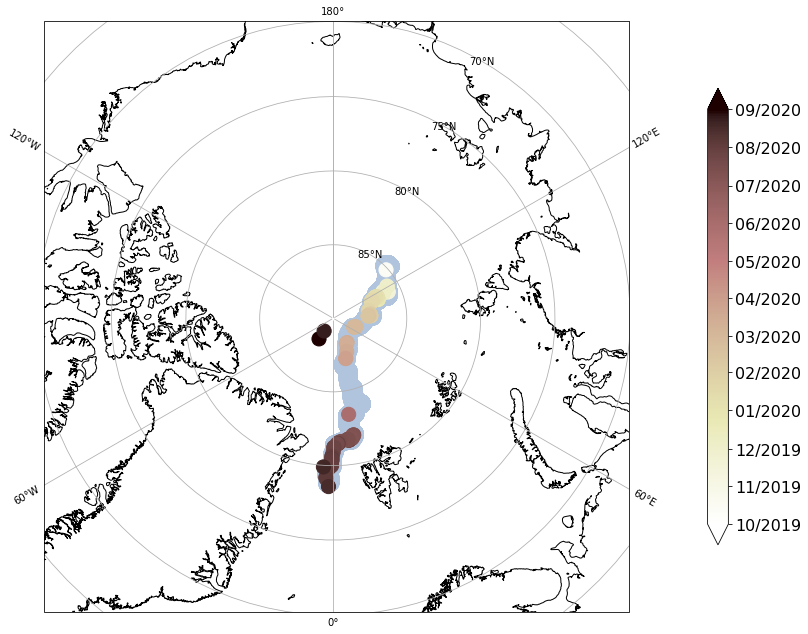

In [80]:
def create_colorbar_ticks(dates):
    # time limits
    dt0, dt1 = datetime.fromordinal(int(dates[0])), datetime.fromordinal(int(dates[-1]))
    monthi, yeari, monthf, yearf = dt0.month, dt0.year, dt1.month, dt1.year
    monthf = monthf+1
    if monthf>12:
        monthf, yearf = 1, yearf + 1
    # create time axis with value at first of each month
    hybridi, hybridf = yeari*100+monthi, yearf*100+monthf
    strmonth= '0'+str(monthi) if monthi>10 else str(monthi)
    ctick=[datetime.strptime(str(yeari) + strmonth, '%Y%m').toordinal()]
    clabel=[strmonth + '/' + str(yeari)]

    while hybridi<hybridf:
        monthi = monthi + 1
        if monthi>12:
            monthi, yeari = 1, yeari+1
        hybridi=yeari*100+monthi
        strmonth= '0'+str(monthi) if monthi<10 else str(monthi)
        ctick.append(datetime.strptime(str(yeari) + strmonth, '%Y%m').toordinal())
        clabel.append(strmonth + '/' + str(yeari))
    return ctick, clabel
    
    
fig,ax = define_map()

plot_extent = [-180, 180, 70, 90]
ax.set_extent(plot_extent, crs=ccrs.PlateCarree())

# topography
extent_limits = [np.min(topography.longitude), np.max(topography.longitude), np.min(topography.latitude), np.max(topography.latitude)]
ax.imshow(topography.topography,cmap='Greys_r', extent=extent_limits, transform=ccrs.PlateCarree())

# MOSAiC track
ax.scatter(trajectory.longitude, trajectory.latitude, c='lightsteelblue', s=300, transform=ccrs.PlateCarree(), label='MOSAiC track')

# measurement point location
ctick, clabel = create_colorbar_ticks(profile.time)
mplot = ax.scatter(profile.longitude, profile.latitude, c=profile.time, s=200, vmin=ctick[0], vmax=ctick[-1], transform=ccrs.PlateCarree(), cmap='pink_r')
cbar = fig.colorbar(mplot,extend='both', shrink=0.6,ax=ax, pad=0.1)

cbar.set_ticks(ctick),cbar.set_ticklabels(clabel),cbar.ax.tick_params(labelsize=16)

#ax.legend()

plt.show()